## A Fourier Neural Operator for DNA replication kinetics ##

A Fourier Neural Operator (FNO) for learning and predicting DNA replication kinetics.

⚠️ This code is part of ongoing research and is not yet licensed for reuse. It is shared for transparency and collaboration purposes only. A publication and proper license will follow.

Requires the `neuraloperator` library: https://github.com/neuraloperator/neuraloperator

### PDE solver (ground truth generation) ###

In [1]:
import numpy as np

# Spatial grid
L = 100.0
Nx = 801 # Spatial resolution (default: 801)
dx = L / (Nx - 1)
x_space = np.linspace(0, L, Nx)

# Fork kinetics parameters
v0 = 0.3 # arbitrary units, adjusted for visualization purposes only
eta = 0.5
beta = 0.4
gamma = 1.0

# Time grid
T_max = 180.0 # arbitrary units, adjusted for visualization purposes only
dt = 0.5 * dx / v0
Nt_steps = int(T_max / dt) + 1
save_every = 20 # Time resolution (default: 20)
time_axis = np.arange(0, T_max + dt, dt)[::save_every]  # length Nt
Nt = len(time_axis)

eps = 1e-8

def initiation_profile(t, t_delay=30.0): # pick t_delay for different kinetics (healthy: 0.0, cancer: 30.0)

    I_left  = 0.02 * np.exp(-0.5 * ((x_space - 30.0) / 1.0)**2)
    I_right = 0.02 * np.exp(-0.5 * ((x_space - 70.0) / 1.0)**2)
    delay_factor = 1.0 / (1.0 + np.exp(-(t - t_delay)/5.0))
    return I_left + delay_factor * I_right

def fork_speed_profile(x, t, D, center=67, width=10, t0=40, tau=10):

    spatial_mod  = np.exp(-0.5 * ((x - center) / width)**2)
    temporal_mod = 1.0 / (1.0 + np.exp(-(t - t0) / tau))
    return v0 * (1.0 - eta * 2 * D * spatial_mod * temporal_mod)

def upwind(arr, speed):

    d = np.empty_like(arr)
    if speed >= 0:
        d[1:] = (arr[1:] - arr[:-1]) / dx
        d[0]  = 0.0
    else:
        d[:-1] = (arr[1:] - arr[:-1]) / dx
        d[-1]  = 0.0
    return d

def run_one_dose(D):

    # Initialize densities & fraction
    rho_p = np.zeros(Nx)    # right‐moving
    rho_m = np.zeros(Nx)    # left‐moving
    sig_p = np.zeros(Nx)    # stalled right forks
    sig_m = np.zeros(Nx)    # stalled left forks
    f_arr = np.zeros(Nx)    # replication fraction

    f_hist = np.zeros((Nt, Nx))
    v_map  = np.zeros((Nt, Nx))
    T95    = np.full((Nx,), np.nan)

    snap_idx = 0
    for step in range(Nt_steps):
        t = step * dt
        I_prof = initiation_profile(t)
        vD     = fork_speed_profile(x_space, t, D)

        # Upwind derivatives
        drho_p_dx = upwind(rho_p, +1.0)
        drho_m_dx = upwind(rho_m, -1.0)

        # Source & sink for forks
        source = I_prof * (1.0 - f_arr)
        sink   = 2.0 * vD * rho_p * rho_m / (1.0 - f_arr + eps)

        # PDE increments
        d_rho_p = -vD * drho_p_dx + source - sink - beta * D * rho_p + gamma * sig_p
        d_rho_m =  vD * drho_m_dx + source - sink - beta * D * rho_m + gamma * sig_m
        d_sig_p =  beta * D * rho_p - gamma * sig_p
        d_sig_m =  beta * D * rho_m - gamma * sig_m
        d_f     =  vD * (rho_p + rho_m)

        rho_p += dt * d_rho_p
        rho_m += dt * d_rho_m
        sig_p += dt * d_sig_p
        sig_m += dt * d_sig_m
        f_arr += dt * d_f

        # Clip to valid ranges
        rho_p = np.clip(rho_p, 0.0, None)
        rho_m = np.clip(rho_m, 0.0, None)
        sig_p = np.clip(sig_p, 0.0, None)
        sig_m = np.clip(sig_m, 0.0, None)
        f_arr = np.clip(f_arr, 0.0, 1.0)

        if step % save_every == 0:
            f_hist[snap_idx, :] = f_arr
            v_map[snap_idx, :]  = vD
            snap_idx += 1

        # Mark T95 where f first ≥ 0.95
        newly_done = (f_arr >= 0.95) & np.isnan(T95)
        if np.any(newly_done):
            T95[newly_done] = t

        # Early‐stop if fully replicated
        if np.all(f_arr >= 0.999):
            T95[np.isnan(T95)] = t
            f_hist = f_hist[:snap_idx, :]
            v_map  = v_map[:snap_idx, :]
            break

    return f_hist, v_map, T95


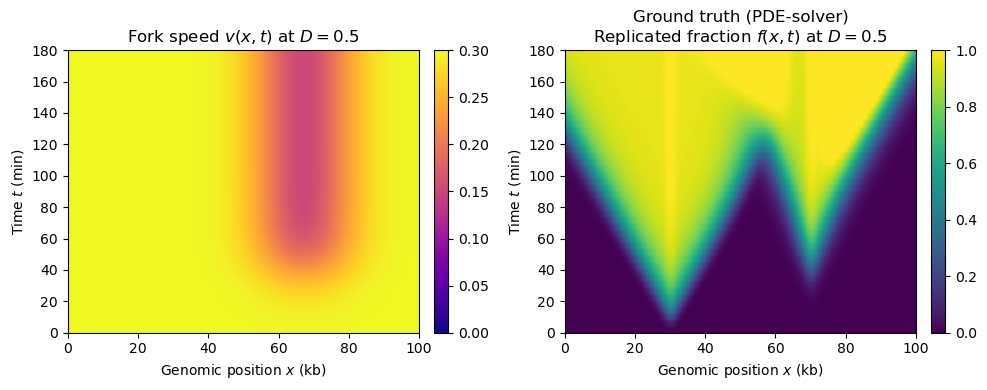

In [2]:
# Example visualization for run_one_dose(D)
import matplotlib.pyplot as plt

# Choose a sample dose for visualization
D_example = 0.5

# Run the PDE solver to get ground‐truth
f_hist_true, v_map_true, T95_example = run_one_dose(D_example)

# Plot fork speed and replication fraction heatmaps side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
extent = [0, L, 0, T_max]  # x from 0→L, y from 0→T_max

# Fork speed heatmap
im_v = axs[0].imshow(
    v_map_true, aspect='auto', origin='lower',
    extent=extent, cmap='plasma', vmin=0.0, vmax=v0
)
axs[0].set_title(f"Fork speed $v(x,t)$ at $D={D_example}$")
axs[0].set_xlabel("Genomic position $x$ (kb)")
axs[0].set_ylabel("Time $t$ (min)")
plt.colorbar(im_v, ax=axs[0], fraction=0.046, pad=0.04)

# Ground‐truth replication fraction heatmap
im_true = axs[1].imshow(
    f_hist_true, aspect='auto', origin='lower',
    extent=extent, cmap='viridis', vmin=0.0, vmax=1.0
)
axs[1].set_title(f"Ground truth (PDE‐solver)\nReplicated fraction $f(x,t)$ at $D={D_example}$")
axs[1].set_xlabel("Genomic position $x$ (kb)")
axs[1].set_ylabel("Time $t$ (min)")
plt.colorbar(im_true, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### Training data generation ###

In [3]:
import torch

# Training set
D_list_train = [0.0, 0.25, 0.5, 0.75, 1.0]
all_inputs  = []
all_outputs = []

for D in D_list_train:
    f_hist, v_map, T95 = run_one_dose(D)  # f_hist: (Nt, Nx)
    I_final = initiation_profile(T_max)   # (Nx,)

    # Input: (2, Nx)
    channel_D = np.full((Nx,), D, dtype=np.float32)
    channel_I = I_final.astype(np.float32)
    input_2xN = np.stack([channel_D, channel_I], axis=0)

    # Output: (Nt, Nx)
    output_NtxN = f_hist.astype(np.float32)

    all_inputs.append(input_2xN)
    all_outputs.append(output_NtxN)

inputs_np  = np.stack(all_inputs)   # (N_train=4, 2, Nx)
outputs_np = np.stack(all_outputs)  # (N_train=4, Nt, Nx)

# Test set (held‐out dose 0.625)
D_list_test = [0.625]
test_inputs  = []
test_outputs = []

for D in D_list_test:
    f_hist, v_map, T95 = run_one_dose(D)
    I_final = initiation_profile(T_max)

    channel_D = np.full((Nx,), D, dtype=np.float32)
    channel_I = I_final.astype(np.float32)
    input_2xN = np.stack([channel_D, channel_I], axis=0)

    output_NtxN = f_hist.astype(np.float32)

    test_inputs.append(input_2xN)
    test_outputs.append(output_NtxN)

test_inputs_np  = np.stack(test_inputs)   
test_outputs_np = np.stack(test_outputs)  

# Convert everything to PyTorch tensors
inputs_tensor   = torch.tensor(inputs_np,  dtype=torch.float32)
outputs_tensor  = torch.tensor(outputs_np, dtype=torch.float32)
test_in_tensor  = torch.tensor(test_inputs_np,  dtype=torch.float32)
test_out_tensor = torch.tensor(test_outputs_np, dtype=torch.float32)


### Custom dataset class ###

In [4]:
from torch.utils.data import Dataset

class ReplicationDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs  = inputs   
        self.outputs = outputs  

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return {
            'x': self.inputs[idx],   
            'y': self.outputs[idx]   
        }

# Build DataLoaders
from torch.utils.data import DataLoader

train_dataset = ReplicationDataset(inputs_tensor, outputs_tensor)
train_loader  = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset  = ReplicationDataset(test_in_tensor, test_out_tensor)
test_loader   = DataLoader(test_dataset, batch_size=1, shuffle=False)


### FNO training ###

In [5]:
import torch
import torch.optim as optim
from neuralop.models import FNO
from neuralop.training import Trainer
from neuralop.losses import LpLoss
from neuralop.data.transforms.data_processors import DefaultDataProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the FNO exactly as before
model = FNO(
    in_channels=2,        # [dose, I_final(x)]
    out_channels=Nt,      # outputs Nt time‐snapshots of f(x,t)
    n_modes=(16,),        # keep 16 Fourier modes over x
    hidden_channels=64    # width of hidden channels
).to(device)

# Create optimizer & (optional) scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# For simplicity, use a StepLR scheduler (optional—you can omit if not needed)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Loss functions
train_loss = LpLoss(d=2, p=2)            # L² norm over (time × space)
eval_losses = {"L2": LpLoss(d=2, p=2)}   # we’ll compute L2 on test set as well

# Data processor
data_processor = DefaultDataProcessor()

# Build the Trainer
trainer = Trainer(
    model=model,
    n_epochs=100, # default: 100
    device=device,
    data_processor=data_processor,
    wandb_log=False,
    eval_interval=5,
    use_distributed=False,
    verbose=True,
)

trainer.train(
    train_loader=train_loader,
    test_loaders={"test": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
)

print("FNO training complete.")


Training on 5 samples
Testing on [1] samples         on resolutions ['test'].
Raw outputs of shape torch.Size([2, 44, 801])
[0] time=0.88, avg_loss=1.0143, train_err=1.6906
Eval: test_L2=0.9832
[5] time=0.35, avg_loss=0.5646, train_err=0.9409
Eval: test_L2=0.5108
[10] time=0.42, avg_loss=0.4243, train_err=0.7072
Eval: test_L2=0.3915
[15] time=0.35, avg_loss=0.3354, train_err=0.5590
Eval: test_L2=0.3014
[20] time=0.46, avg_loss=0.2503, train_err=0.4172
Eval: test_L2=0.1995
[25] time=0.35, avg_loss=0.1838, train_err=0.3063
Eval: test_L2=0.1551
[30] time=0.45, avg_loss=0.1558, train_err=0.2597
Eval: test_L2=0.1696
[35] time=0.41, avg_loss=0.1205, train_err=0.2009
Eval: test_L2=0.1281
[40] time=0.35, avg_loss=0.1238, train_err=0.2063
Eval: test_L2=0.1009
[45] time=0.38, avg_loss=0.0861, train_err=0.1435
Eval: test_L2=0.0851
[50] time=0.35, avg_loss=0.0833, train_err=0.1388
Eval: test_L2=0.0736
[55] time=0.40, avg_loss=0.0735, train_err=0.1224
Eval: test_L2=0.0696
[60] time=0.35, avg_loss=0

### Comparison between ground truth and FNO prediction ###

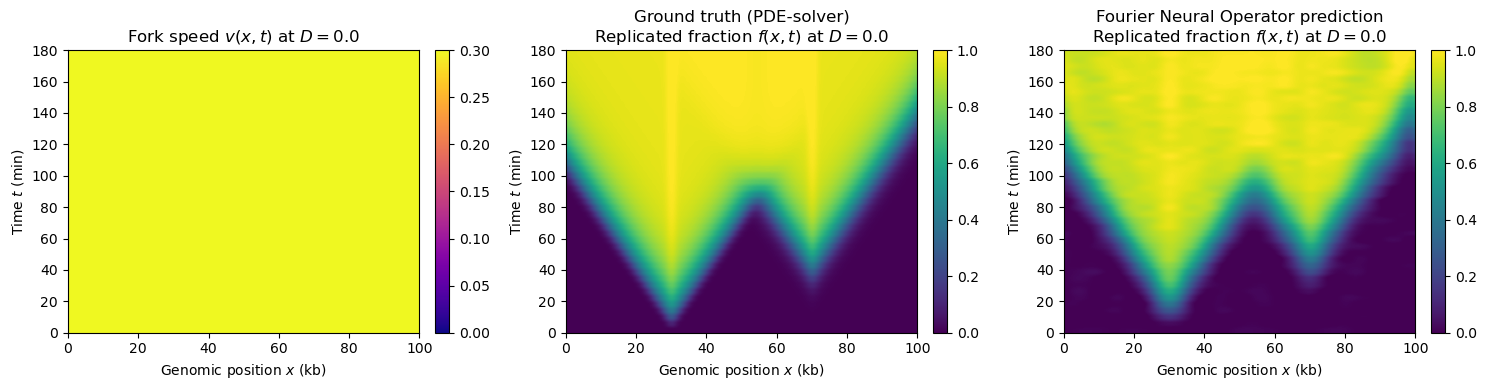

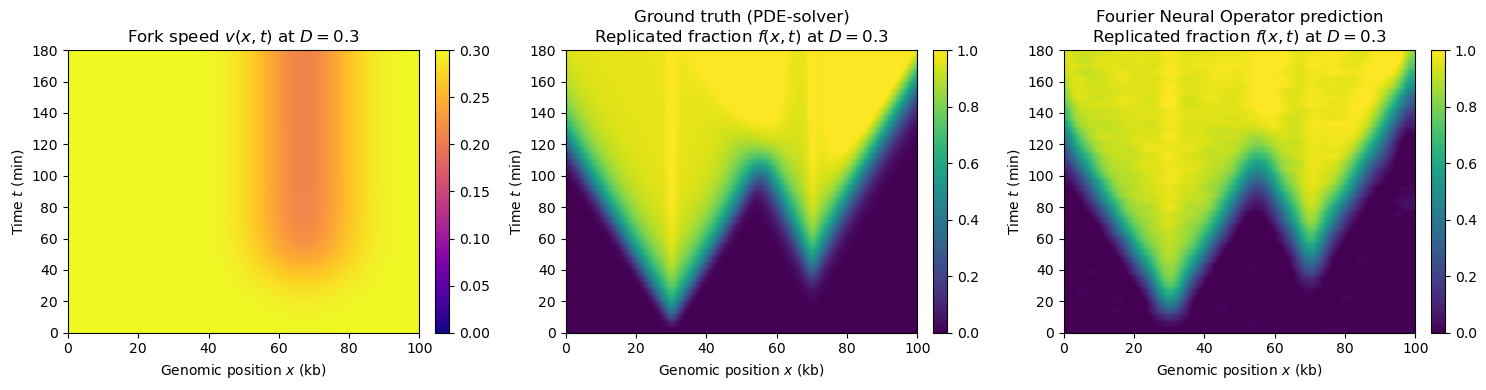

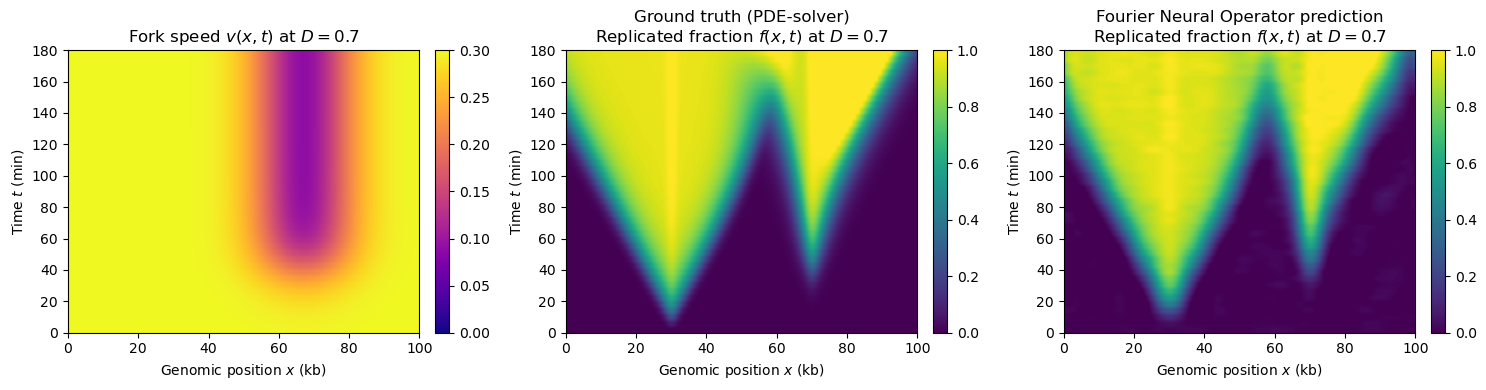

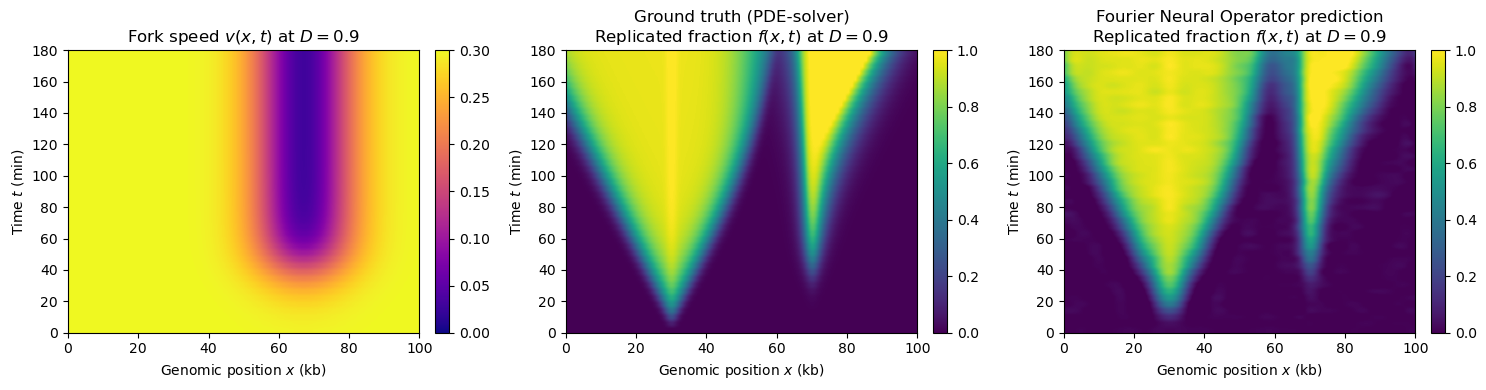

In [6]:
import matplotlib.pyplot as plt

# Define a range of doses to evaluate (beyond the single held‐out dose)
D_plot_list = [0., 0.3, 0.7, 0.9] 

# Precompute "final" initiation profile once
I_final = initiation_profile(T_max)

model.eval()
with torch.no_grad():
    for D in D_plot_list:
        # Generate ground truth via PDE solver (get both f and v)
        f_hist_true, v_map_true, _ = run_one_dose(D) 

        # Build the FNO input tensor: (1, 2, Nx)
        D_channel = np.full((Nx,), D, dtype=np.float32)
        input_np   = np.stack([D_channel, I_final], axis=0)       
        input_tensor = torch.tensor(input_np[None, ...], dtype=torch.float32).to(device)

        # FNO predict
        y_hat       = model(input_tensor)                         
        f_hist_pred = y_hat.cpu().numpy()[0]                      

        # Plot: left = fork speed v(x,t), middle = true f(x,t), right = predicted f(x,t)
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        extent = [0, L, 0, T_max]

        # Fork speed heatmap
        im_v = axs[0].imshow(
            v_map_true, aspect='auto', origin='lower',
            extent=extent, cmap='plasma', vmin=0.0, vmax=v0
        )
        axs[0].set_title(f"Fork speed $v(x,t)$ at $D={D}$")
        axs[0].set_xlabel("Genomic position $x$ (kb)")
        axs[0].set_ylabel("Time $t$ (min)")
        plt.colorbar(im_v, ax=axs[0], fraction=0.046, pad=0.04)

        # Ground‐truth replication fraction heatmap
        im_true = axs[1].imshow(
            f_hist_true, aspect='auto', origin='lower',
            extent=extent, cmap='viridis', vmin=0.0, vmax=1.0
        )
        axs[1].set_title(f"Ground truth (PDE‐solver)\nReplicated fraction $f(x,t)$ at $D={D}$")
        axs[1].set_xlabel("Genomic position $x$ (kb)")
        axs[1].set_ylabel("Time $t$ (min)")
        plt.colorbar(im_true, ax=axs[1], fraction=0.046, pad=0.04)

        # FNO‐predicted replication fraction heatmap
        im_pred = axs[2].imshow(
            f_hist_pred, aspect='auto', origin='lower',
            extent=extent, cmap='viridis', vmin=0.0, vmax=1.0
        )
        axs[2].set_title(f"Fourier Neural Operator prediction\nReplicated fraction $f(x,t)$ at $D={D}$")
        axs[2].set_xlabel("Genomic position $x$ (kb)")
        axs[2].set_ylabel("Time $t$ (min)")
        plt.colorbar(im_pred, ax=axs[2], fraction=0.046, pad=0.04)

        plt.tight_layout()

        if False:
            fig.savefig("fno_results.pdf", transparent=True, bbox_inches='tight')
        
        plt.show()


### High-resolution scanning of drug dosage and cell fate ###

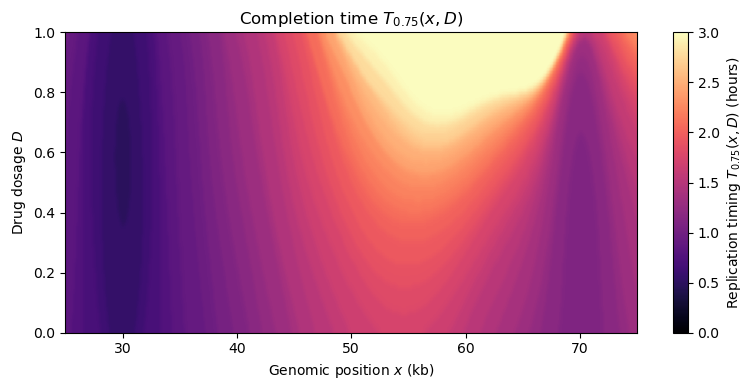

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch

D_plot_list = np.linspace(0.0, 1.0, 101, dtype=np.float32)
model.eval()
I_final = initiation_profile(T_max).astype(np.float32)
L = 100.0

# Choose the replication threshold (value) and convert T to hours later
threshold = 0.75

Tval_matrix = np.zeros((len(D_plot_list), Nx), dtype=np.float32)

with torch.no_grad():
    for i, D in enumerate(D_plot_list):
        D_channel    = np.full((Nx,), D, dtype=np.float32)
        input_np     = np.stack([D_channel, I_final], axis=0)
        input_tensor = torch.tensor(input_np[None, ...], dtype=torch.float32).to(device)

        f_pred = model(input_tensor).cpu().numpy()[0]  # (Nt, Nx)

        for j in range(Nx):
            above = np.where(f_pred[:, j] >= threshold)[0]
            if above.size > 0:
                # Convert minutes to hours
                Tval_matrix[i, j] = time_axis[above[0]] / 60.0
            else:
                Tval_matrix[i, j] = T_max / 60.0  # fallback to max time in hours

# Apply Gaussian smoothing to Tval_matrix (optional)
Tval_smoothed = gaussian_filter(Tval_matrix, sigma=(1, 1))

plt.figure(figsize=(8, 4))
extent = [0, L, D_plot_list[0], D_plot_list[-1]]

plt.imshow(
    Tval_smoothed,
    origin='lower',
    aspect='auto',
    extent=extent,
    cmap='magma',
    vmin=0,
    vmax=T_max / 60.  # force colorbar range from 0 to 8
)

plt.colorbar(label=f"Replication timing $T_{{{threshold}}}(x,D)$ (hours)")
plt.xlabel("Genomic position $x$ (kb)")
plt.ylabel("Drug dosage $D$")
plt.title(f"Completion time $T_{{{threshold}}}(x,D)$")
plt.xlim(25, 75)
plt.tight_layout()
if False:
    plt.savefig("time_results.pdf", transparent=True, bbox_inches='tight')
plt.show()

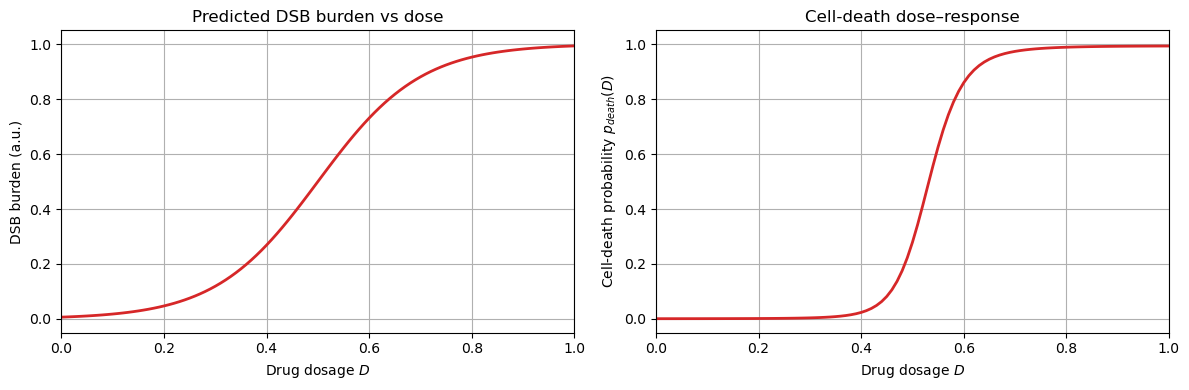

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define DSB
k  = 10.0
D0 = 0.5
DSB = 1.0 / (1.0 + np.exp(-k * (D_plot_list - D0)))  # shape: (N,)

T_mean = np.mean(Tval_matrix)
# These serve merely for illustrative purposes, will be clinically informed and adjusted
alpha = -37 * T_mean + 78
theta = -1.3 * T_mean + 2.9

# Compute cell-death probability p_death(D)
p_death = 1.0 / (1.0 + np.exp(-alpha * (DSB - theta)))
p_death = np.clip(p_death, 0.0, 1.0)

# Plot DSB burden and cell-death curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# DSB burden vs dose
ax[0].plot(D_plot_list, DSB, '-', color='tab:red', linewidth=2)
ax[0].set_xlabel("Drug dosage $D$")
ax[0].set_ylabel("DSB burden (a.u.)")
ax[0].set_title("Predicted DSB burden vs dose")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(-0.05, 1.05)
ax[0].grid(True)

# Cell‐death probability vs dose
ax[1].plot(D_plot_list, p_death, '-', color='tab:red', linewidth=2)
ax[1].set_xlabel("Drug dosage $D$")
ax[1].set_ylabel("Cell‐death probability $p_{death}(D)$")
ax[1].set_title("Cell‐death dose–response")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(-0.05, 1.05)
ax[1].grid(True)

plt.tight_layout()
plt.show()


### Timing benchmark: FNO vs PDE solver ###

In [9]:
import time
import numpy as np
import torch

# WARNING: long computation
# Naturally, performance will improve with resolution, genomic region size, and PDE number
# Even in a relatively small context, FNO outperform classical solvers.

# Define the dosage range
D_int = 0.01
D_range = np.arange(0.0, 1.+D_int, D_int, dtype=np.float32)

# Precompute the final initiation profile once
I_final = initiation_profile(T_max).astype(np.float32)

# Build a batched input tensor for all doses
num_doses = len(D_range)
batch_np = np.zeros((num_doses, 2, Nx), dtype=np.float32)
for i, D in enumerate(D_range):
    batch_np[i, 0, :] = D         # channel 0 = dose
    batch_np[i, 1, :] = I_final   # channel 1 = I_final

# Move the entire batch to the correct device once
batch_tensor = torch.tensor(batch_np, device=device)

# Warm up: one PDE solve and one FNO inference (to avoid JIT overhead)
_ = run_one_dose(float(D_range[0]))
with torch.no_grad():
    _ = model(batch_tensor[:1, ...])
if device.type == "cuda":
    torch.cuda.synchronize()

# Time the full PDE sweep (looping over each dose)
pde_start = time.perf_counter()
for D in D_range:
    _ = run_one_dose(float(D))
pde_end = time.perf_counter()
total_pde_time = pde_end - pde_start

# Time the batched FNO inference (single forward pass)
with torch.no_grad():
    if device.type == "cuda":
        torch.cuda.synchronize()
    fno_start = time.perf_counter()
    _ = model(batch_tensor)  
    if device.type == "cuda":
        torch.cuda.synchronize()
    fno_end = time.perf_counter()
total_fno_time = fno_end - fno_start

# Report results
avg_pde_time = total_pde_time / num_doses
avg_fno_time = total_fno_time / num_doses
overall_speedup = total_pde_time / total_fno_time if total_fno_time > 0 else float("inf")

print(f"Dosage sweep: {num_doses} values from 0.0 to 1.0 step {D_int}")
print(f"Total PDE time     = {total_pde_time:.4f} s  ({avg_pde_time:.4f} s per dose)")
print(f"Total FNO time     = {total_fno_time:.4f} s  ({avg_fno_time:.4f} s per dose)")
print(f"Aggregate speedup  = {overall_speedup:.1f}×") # Increases with resolution


Dosage sweep: 101 values from 0.0 to 1.0 step 0.01
Total PDE time     = 10.2051 s  (0.1010 s per dose)
Total FNO time     = 0.2499 s  (0.0025 s per dose)
Aggregate speedup  = 40.8×


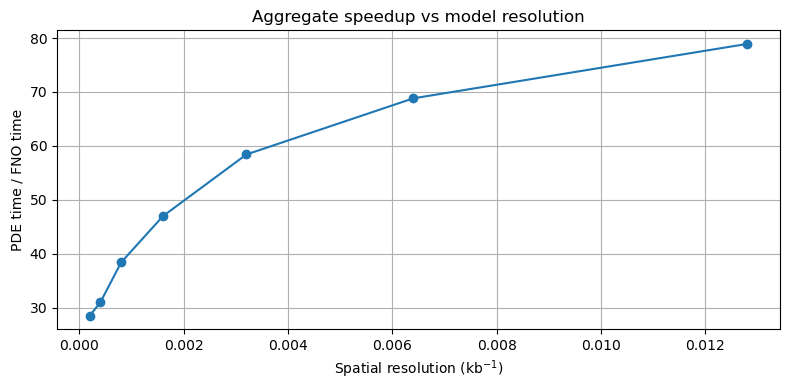

In [10]:
# Speed vs resolution (bp, kb, Mb, etc.)
L = 1e9  # genomic region length in base pairs (example)
N_x_list = [201, 401, 801, 1601, 3201, 6401, 12801]
# Results obtained by varying N_x
speedups = [28.52466493, 30.96033935, 38.39209708, 46.9549573, 58.39501887525142, 68.8084881352017, 78.903240193]
resolution_kb_inv = [N / (L / 1e3) for N in N_x_list]  # resolution in kb^{-1}
plt.figure(figsize=(8, 4))
plt.plot(resolution_kb_inv, speedups, marker='o', linestyle='-')

plt.title("Aggregate speedup vs model resolution")
plt.xlabel("Spatial resolution (kb$^{-1}$)")
plt.ylabel("PDE time / FNO time")
plt.grid(True)
plt.tight_layout()
if False:
    plt.savefig("speed_results.pdf", transparent=True, bbox_inches='tight')
plt.show()

### Preliminary data: fork speed under treatment ###

Here, we import preliminary data from Jones et al. (2022) that maps replication fork speeds in COLO 320DM colorectal adenocarcinoma cells

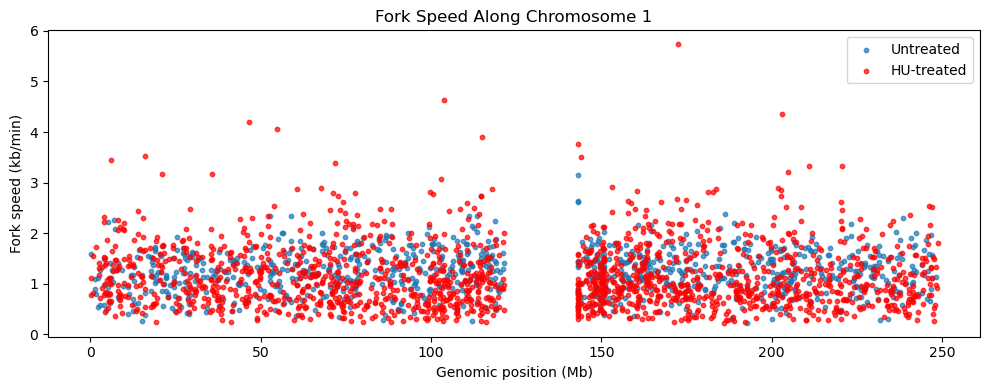

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
chr_number = 1
chromosome_id = f"NC_00000{chr_number}.11"

# Load & filter untreated data
df_untreated = pd.read_csv('COLO320DM_DM_hg38.csv')
chr_untreated = df_untreated[df_untreated['chromosome'] == chromosome_id].dropna(subset=['fork_speed'])
pos_untreated = ((chr_untreated['fork_lb'] + chr_untreated['fork_ub']) / 2) / 1e6
speed_untreated = chr_untreated['fork_speed']

# Load & filter HU-treated data
df_treated = pd.read_csv('COLO320DM_DM_hg38_HU.csv')
chr_treated = df_treated[df_treated['chromosome'] == chromosome_id].dropna(subset=['fork_speed'])
pos_treated = ((chr_treated['fork_lb'] + chr_treated['fork_ub']) / 2) / 1e6
speed_treated = chr_treated['fork_speed']

# Plot
plt.figure(figsize=(10, 4))
plt.scatter(pos_untreated, speed_untreated, s=10, alpha=0.7, label='Untreated')
plt.scatter(pos_treated, speed_treated, s=10, alpha=0.7, color='red', label='HU-treated')
plt.xlabel('Genomic position (Mb)')
plt.ylabel('Fork speed (kb/min)')
plt.title(f'Fork Speed Along Chromosome {chr_number}')
plt.legend()
plt.tight_layout()
plt.show()


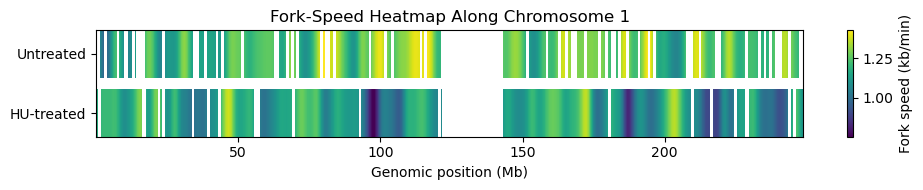

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Parameters
chr_number    = 1
chromosome_id = f"NC_00000{chr_number}.11"
Nbins         = 500    # number of genomic bins (controls horizontal resolution)
smooth_sigma  = 3      # smoothing width (in bin units)
stripe_height = 0.4    # height of each heat bar
gap           = 0.1    # vertical gap between bars

# Load & filter untreated data
df_u = pd.read_csv('COLO320DM_DM_hg38.csv')
df_u = df_u[df_u['chromosome'] == chromosome_id].dropna(subset=['fork_speed'])
pos_u  = ((df_u['fork_lb'] + df_u['fork_ub']) / 2) / 1e6
speed_u = df_u['fork_speed'].values

# Load & filter HU-treated data
df_t = pd.read_csv('COLO320DM_DM_hg38_HU.csv')
df_t = df_t[df_t['chromosome'] == chromosome_id].dropna(subset=['fork_speed'])
pos_t  = ((df_t['fork_lb'] + df_t['fork_ub']) / 2) / 1e6
speed_t = df_t['fork_speed'].values

# Define genomic bins
pos_min = min(pos_u.min(), pos_t.min())
pos_max = max(pos_u.max(), pos_t.max())
bins    = np.linspace(pos_min, pos_max, Nbins + 1)

# Compute mean fork speed per bin
heat_u = np.full(Nbins, np.nan)
inds_u = np.digitize(pos_u, bins) - 1
for i in range(Nbins):
    vals = speed_u[inds_u == i]
    if vals.size:
        heat_u[i] = vals.mean()

heat_t = np.full(Nbins, np.nan)
inds_t = np.digitize(pos_t, bins) - 1
for i in range(Nbins):
    vals = speed_t[inds_t == i]
    if vals.size:
        heat_t[i] = vals.mean()

# Smooth while preserving NaNs
filled_u  = np.nan_to_num(heat_u, nan=np.nanmean(heat_u))
filled_t  = np.nan_to_num(heat_t, nan=np.nanmean(heat_t))
smooth_u  = gaussian_filter1d(filled_u, sigma=smooth_sigma)
smooth_t  = gaussian_filter1d(filled_t, sigma=smooth_sigma)
heat_u_sm = np.ma.array(smooth_u, mask=np.isnan(heat_u))
heat_t_sm = np.ma.array(smooth_t, mask=np.isnan(heat_t))

# Shared color scale
combined = np.concatenate([heat_u_sm.compressed(), heat_t_sm.compressed()])
vmin, vmax = combined.min(), combined.max()

# Plot
fig, ax = plt.subplots(figsize=(10, 2))
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# HU-treated stripe (bottom)
ax.imshow(heat_t_sm[np.newaxis, :], aspect='auto', cmap=cmap,
          vmin=vmin, vmax=vmax,
          extent=[pos_min, pos_max, 0, stripe_height],
          origin='lower')
# Untreated stripe (top)
ax.imshow(heat_u_sm[np.newaxis, :], aspect='auto', cmap=cmap,
          vmin=vmin, vmax=vmax,
          extent=[pos_min, pos_max, stripe_height + gap, 2*stripe_height + gap],
          origin='lower')

ax.set_xlim(pos_min, pos_max)
ax.set_ylim(0, 2*stripe_height + gap)
ax.set_yticks([stripe_height/2, stripe_height + gap + stripe_height/2])
ax.set_yticklabels(['HU-treated', 'Untreated'])
ax.set_xlabel('Genomic position (Mb)')
ax.set_title(f'Fork-Speed Heatmap Along Chromosome {chr_number}')

# Colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                    ax=ax, orientation='vertical', label='Fork speed (kb/min)')
plt.tight_layout()
plt.savefig("speed_data.pdf", transparent=True, bbox_inches='tight')
plt.show()
